In [1]:
import pairtools
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
from NGS import HiCTools as HT
from collections import defaultdict

# Define plotting parameters

In [56]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [2]:
def recDict():
    return defaultdict(recDict)

# Set WD

In [3]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004869/")

# Define samples

In [4]:
pairDir = {"CAGATC_merged":"/groups/gerlich/experiments/Experiments_004800/004869/"
           "Sequencing_data/Pooled/Pairs/",
           "ACTTGA_merged": "/groups/gerlich/experiments/Experiments_004800/004869/"
           "Sequencing_data/Pooled/Pairs/",
           "GGCTAC_S1": "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/Novaseq/pairs/",
            "GTGAAA_S11": "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/Novaseq/pairs",
            "TTAGGC_merged":"/groups/gerlich/experiments/Experiments_004800/004869/"
           "Sequencing_data/Pooled/Pairs/",
           "GATCAG_merged": "/groups/gerlich/experiments/Experiments_004800/004869/"
           "Sequencing_data/Pooled/Pairs/",
           "GCCAAT": "/groups/gerlich/experiments/Experiments_004600/004655/Sequencing_data/Novaseq/Pairs/",
           "G2": "/groups/gerlich/experiments/Experiments_004600/004661/Sequencing_data/pairs/"}

sampleMap = {"CAGATC_merged": "Nipbl_w_auxin rep1",
             "ACTTGA_merged": "Nipbl_w_auxin rep2",
             "GGCTAC_S1": "Nipbl_w_auxin rep3",
             "GTGAAA_S11": "Nipbl_w_auxin rep4",
             "TTAGGC_merged": "Sororin_w_auxin rep1",
             "GATCAG_merged": "Sororin_w_auxin rep2",
             "GCCAAT": "Sororin_w_auxin rep3",
             "G2": "WT pooled"}

# Load samples

In [5]:
pairs = {}
for barcode, name in sampleMap.items():
    pairs[name] = {}
    pairs[name]["cis"] = HT.loadPairs(
        os.path.join(pairDir[barcode], f"{barcode}.cis.pairs.gz"))
    pairs[name]["trans"] = HT.loadPairs(
        os.path.join(pairDir[barcode], f"{barcode}.trans.pairs.gz"))

# Merge replicates

In [36]:
pairsMerged = recDict()
pairsMerged["Nipbl_w_auxin"]["cis"] = pd.concat((pairs["Nipbl_w_auxin rep1"]["cis"], pairs["Nipbl_w_auxin rep2"]["cis"], pairs["Nipbl_w_auxin rep3"]["cis"], pairs["Nipbl_w_auxin rep4"]["cis"]))
pairsMerged["Nipbl_w_auxin"]["trans"] = pd.concat((pairs["Nipbl_w_auxin rep1"]["trans"], pairs["Nipbl_w_auxin rep2"]["trans"], pairs["Nipbl_w_auxin rep3"]["trans"], pairs["Nipbl_w_auxin rep4"]["trans"]))
pairsMerged["Sororin_w_auxin"]["cis"] = pd.concat((pairs["Sororin_w_auxin rep1"]["cis"], pairs["Sororin_w_auxin rep2"]["cis"], pairs["Sororin_w_auxin rep3"]["cis"]))
pairsMerged["Sororin_w_auxin"]["trans"] = pd.concat((pairs["Sororin_w_auxin rep1"]["trans"], pairs["Sororin_w_auxin rep2"]["trans"], pairs["Sororin_w_auxin rep3"]["trans"]))
pairsMerged["WT"]["cis"] = pairs["WT pooled"]["cis"]
pairsMerged["WT"]["trans"] = pairs["WT pooled"]["trans"]

# Downsample pairs

In [37]:
pairsNew = HT.downSamplePairs(pairsMerged, Distance=1000)

# Get chromosome features

In [38]:
hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

# Calculate scaling plots

In [39]:
scs = {sample: {rType: pairlib.scalings.compute_scaling(
    pairsNew[sample][rType],
    arms,
    hg19_chromsizes
) for rType in ["cis", "trans"]}
    for sample in pairsNew.keys()
}

# Plot results

## cis

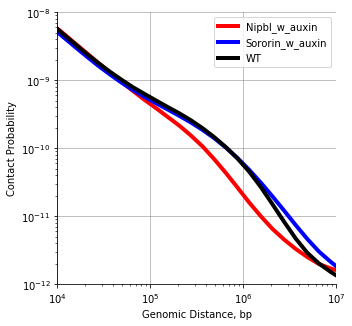

In [57]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

cmapDict = {"Nipbl_w_auxin": "red",
            "Sororin_w_auxin": "blue",
            "WT": "black"}

f, ax = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.7)
for index, sample in enumerate(pairsNew.keys()):
    for rType in ["cis"]:
        sc = scs[sample][rType]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax.loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            sc_agg.n_pairs / sc_agg.n_bp2,
            label=f'{sample}',
            linewidth=4, color=cmapDict[sample])
    ax.grid(lw=0.5, color='gray')
    ax.set_xlim(10**4, 10**7)
    ax.set_ylim(10**-12, 10**-8)
    ax.legend()
    ax.set_xlabel("Genomic Distance, bp")
    ax.set_ylabel("Contact Probability")
f.set_size_inches(5, 5)
sbn.despine()
plt.show()

## write to file

In [58]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results"
f.savefig(os.path.join(resultsdir, "Scaling_plot_cis_Nipbl_Sororin_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Scaling_plot_cis_Nipbl_Sororin_WT.pdf"), bbox_inches="tight")

## trans

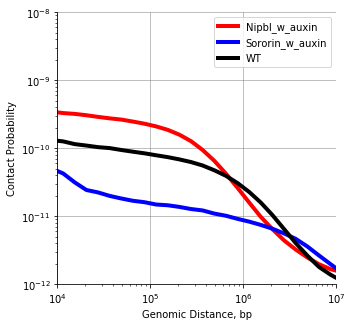

In [59]:
cmapDict = {"Nipbl_w_auxin": "red",
            "Sororin_w_auxin": "blue",
            "WT": "black"}

f, ax = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.7)
for index, sample in enumerate(pairsNew.keys()):
    for rType in ["trans"]:
        sc = scs[sample][rType]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax.loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            sc_agg.n_pairs / sc_agg.n_bp2,
            label=f'{sample}',
            linewidth=4, color=cmapDict[sample])
    ax.grid(lw=0.5, color='gray')
    ax.set_xlim(10**4, 10**7)
    ax.set_ylim(10**-12, 10**-8)
    ax.legend()
    ax.set_xlabel("Genomic Distance, bp")
    ax.set_ylabel("Contact Probability")
f.set_size_inches(5, 5)
sbn.despine()
plt.show()

In [60]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results"
f.savefig(os.path.join(resultsdir, "Scaling_plot_trans_Nipbl_Sororin_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Scaling_plot_trans_Nipbl_Sororin_WT.pdf"), bbox_inches="tight")